# Capstone Project - Analysis of Manhattan Neighborhoods

## Table of Contents
1. [Introduction : Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)

## Introduction : Business Problem <a name=introduction></a>

This project tries to find an optimal location for opening a new fitness center(Gym/Yoga Studio) in Manhattan, New York, USA. Specifically, this report targets the stakeholders that are interested in opening either gym or yoga studio.

In order to determine an optimal place, this project focuses on following conditions - 
1. To find locations that are not much crowded with fitness centers as compared to other locations. 
2. To be particularly interested in areas with no Gym/Yoga Studio in vicinity. 
3. To prefer locations as close to city center as possible, provided that above two conditions are met.

With data science, this project generates a few most promising neighborhoods based on the above mentioned criteria. Advantages of each area will then be clearly expressed so that the best possible final location can be chosen by stakeholders.

## Data <a name=data></a>
Based on definition of the problem, factors that influence the decision are:
- Number of existing fitness centers(any type) in the neighborhood
- Number of Gyms/Yoga Studios in the neighborhood and their distance(if any)
- Distance of neighborhood from city center

Project uses all the neighborhoods of city, located around city center, to define the city surroundings.

Following data sources are used to extract/generate the required information:
- Neighborhoods of Manhattan are obtained in the form of json file from link 'https://cocl.us/new_york_dataset'
- Number of fitness centers, their type and location present in every neighborhood are obtained using Foursquare API
- Coordinates of Manhattan center are obtained using Geocoders(of GeoPy library) of well-known Manhattan location (Times Square)

### Neighborhood
Getting latitude and longitude of Manhattan center - 'Times Square' using geopy library -

In [1]:
from geopy.geocoders import Nominatim

address = 'Times Square, Manhattan, NY'
geolocator = Nominatim(user_agent='mh_explorer')
location = geolocator.geocode(address)
mh_center = (location.latitude, location.longitude)
print('Geographical Coordinates of Times Square, Manhattan, New York : ', mh_center)

Geographical Coordinates of Times Square, Manhattan, New York :  (40.7568162, -73.9860313157245)


Getting json data of all the boroughs present in New York along with their neighborhoods and geographical coordinates -  

In [2]:
import requests

json_data = requests.get('https://cocl.us/new_york_dataset').json()['features']
json_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

Converting json data into pandas dataframe with the required columns such as borough name, neighborhood, latitude and longitude -

In [3]:
import pandas as pd

ny_neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
#adding data in dataframe
for data in json_data:
    ny_neighborhoods = ny_neighborhoods.append({'Borough': data['properties']['borough'], 
                                                'Neighborhood' : data['properties']['name'],
                                                'Latitude': data['geometry']['coordinates'][1],
                                                'Longitude': data['geometry']['coordinates'][0] },
                                               ignore_index = True)

ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


As this project only focuses on Manhattan borough of New York, all the remaining boroughs are ignored.

In [4]:
manhattan_data = ny_neighborhoods[ny_neighborhoods['Borough'] == 'Manhattan']
manhattan_data.reset_index(inplace=True, drop=True)
print('No. of neighborhoods = ',manhattan_data.shape[0])
manhattan_data.head()

No. of neighborhoods =  40


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Visualizing neighborhoods data of Manhattan on map using Folium - 

In [5]:
!pip install folium
import folium

    100% |████████████████████████████████| 92kB 7.0MB/s eta 0:00:01
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: jinja2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->folium)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->folium)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Py

In [6]:
map_manhattan = folium.Map(height=1000,location=mh_center, zoom_start=12)
folium.Marker(mh_center, popup='Times Square').add_to(map_manhattan)
#plotting manhattan neighborhoods on map
for lat, lon, name in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    folium.CircleMarker([lat, lon], 
                        radius=5, 
                        popup=name,
                        color='blue', 
                        fill=True, 
                        fill_color='blue', 
                        fill_opacity=1).add_to(map_manhattan) 

map_manhattan

All the coordinates of Manhattan Neighborhoods are obtained and plotted. As seen in the above map, a few of the neighborhoods are cosiderably distant from 'Times Squares' while others are pretty close.

Calculating distance between 'Times Square' and each neighborhood using 'geopy' library and updating dataframe 'manhattan_data' with a new column having distance values -

In [7]:
from geopy import distance

distances = []
# Calculate distances(in km) of all neighborhoods from Times Square(city center)
for lat, lng in zip(manhattan_data['Latitude'], manhattan_data['Longitude']):
    location = (lat, lng)
    distances.append(distance.distance(location, mh_center).km)

#adding distance column    
manhattan_data['Distance from Center'] = distances
manhattan_data

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Borough,Neighborhood,Latitude,Longitude,Distance from Center
0,Manhattan,Marble Hill,40.876551,-73.910660,14.738890
1,Manhattan,Chinatown,40.715618,-73.994279,4.627710
2,Manhattan,Washington Heights,40.851903,-73.936900,11.344068
3,Manhattan,Inwood,40.867684,-73.921210,13.471990
4,Manhattan,Hamilton Heights,40.823604,-73.949688,8.026093
5,Manhattan,Manhattanville,40.816934,-73.957385,7.100469
6,Manhattan,Central Harlem,40.815976,-73.943211,7.498261
7,Manhattan,East Harlem,40.792249,-73.944182,5.288173
8,Manhattan,Upper East Side,40.775639,-73.960508,3.002175
9,Manhattan,Yorkville,40.775930,-73.947118,3.911513


The neighborhoods 'Marble Hill', 'Inwood', 'Washington Heights' are farther from 'Times Square' whereas neighborhoods 'Midtown', 'Clinton', 'Midtown South' are closer. Selecting neighboroods that are within 9 km of 'Times Square' - 

In [8]:
manhattan_data = manhattan_data[manhattan_data['Distance from Center'] < 9]
manhattan_data.reset_index(inplace=True,drop=True)
print("No. of neighborhoods : ", manhattan_data.shape[0])

No. of neighborhoods :  37


### Foursquare
Setting Client Id and Client Secret for Foursquare API -

In [9]:
# The code was removed by Watson Studio for sharing.

Getting all fitness center venues present within 1 km of each neighborhood of Manhattan using Foursquare API call - 

In [10]:
#Setting parameters required for foursquare api call
limit = 100
version = '20190425'
radius = 1000

#Root category for all fitness related centers as mentioned on Foursquare website(https://developer.foursquare.com/docs/resources/categories)
category = '4bf58dd8d48988d175941735'

venue_list = []
#Fetching ftiness venues for all neighborhoods
for name, lat, lon in zip(manhattan_data['Neighborhood'], manhattan_data['Latitude'], manhattan_data['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    print(name)
    results = requests.get(url).json()['response']['groups'][0]['items']
    #adding all the venues returned for neighborhood in list
    venue_list.append([( name,
                        lat,
                        lon,
                        item['venue']['name'],
                        item['venue']['categories'][0]['name'], 
                        item['venue']['categories'][0]['id'],                        
                        ','.join(item['venue']['location']['formattedAddress']),
                        item['venue']['location']['distance'],
                        item['venue']['location']['lat'],
                        item['venue']['location']['lng']) for item in results])

Chinatown
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Converting this list of venues into a dataframe - 

In [11]:
mh_venue = pd.DataFrame([item for venue in venue_list for item in venue])
mh_venue.columns = ['Neighborhood','Latitude','Longitude','Venue Name','Category Name','Category Id','Address','Distance','Venue_Lat','Venue_Lng']

In [12]:
print('Total number of venues returned for all neighborhoods = ',mh_venue.shape[0])
mh_venue.head()

Total number of venues returned for all neighborhoods =  3113


,Neighborhood,Latitude,Longitude,Venue Name,Category Name,Category Id,Address,Distance,Venue_Lat,Venue_Lng
0,Chinatown,40.715618,-73.994279,Manny Cantor Center,Gym / Fitness Center,4bf58dd8d48988d175941735,"197 E Broadway (Jefferson Street),New York, NY...",522,40.714086,-73.988422
1,Chinatown,40.715618,-73.994279,Bowery CrossFit,Gym,4bf58dd8d48988d176941735,"285 Grand St,New York, NY 10002,United States",281,40.717812,-73.992624
2,Chinatown,40.715618,-73.994279,Coss Athletics,Gym / Fitness Center,4bf58dd8d48988d175941735,"38 Delancey St Fl 2 (at Forsyth St),New York, ...",535,40.720218,-73.992425
3,Chinatown,40.715618,-73.994279,Hit House,Gym / Fitness Center,4bf58dd8d48988d175941735,"2 Spring St,New York, NY 10012,United States",603,40.721026,-73.993837
4,Chinatown,40.715618,-73.994279,ConBody,Gym,4bf58dd8d48988d176941735,"294 Broome St (Eldridge Street),New York, NY 1...",392,40.718700,-73.992028


Checking if there are any NaN values in above dataframe - 

In [13]:
mh_venue.isna().sum()

Neighborhood     0
Latitude         0
Longitude        0
Venue Name       0
Category Name    0
Category Id      0
Address          0
Distance         0
Venue_Lat        0
Venue_Lng        0
dtype: int64

Determining number of gyms/yoga studios present in each neighborhood and visualizing it with bar graph - 

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


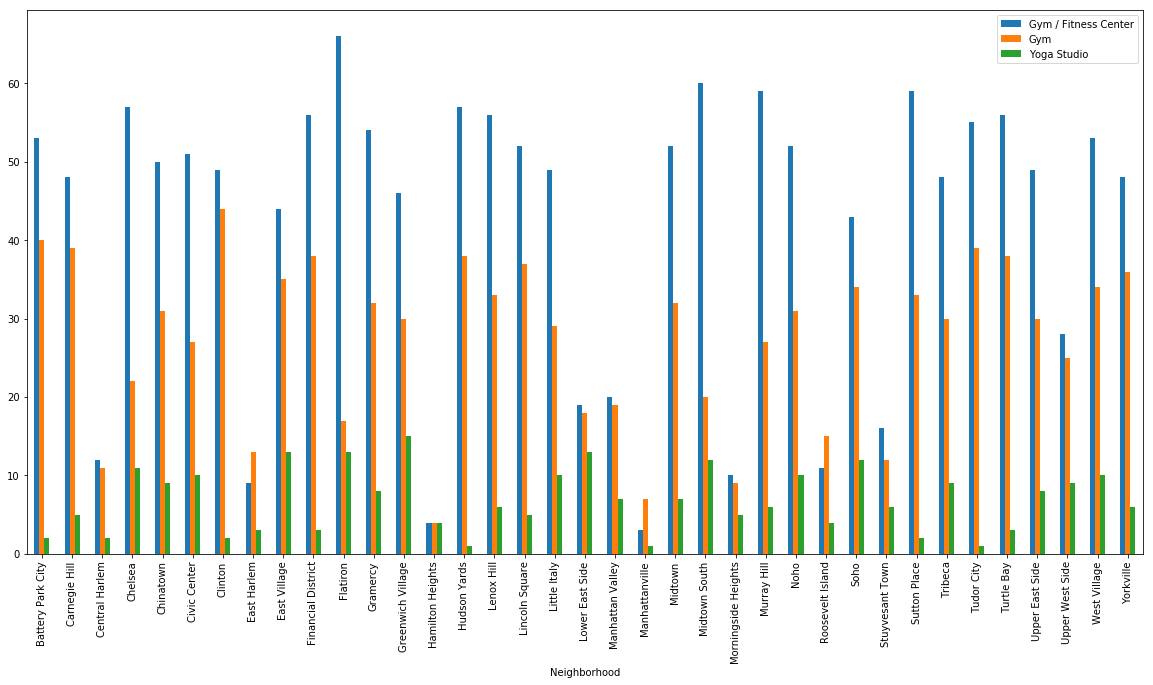

In [14]:
% matplotlib inline

mhonehot = mh_venue.set_index('Neighborhood')
#converting dataframe with categorical data of column Category Name into numerical data with get_dummies
mhonehot = pd.get_dummies(mhonehot['Category Name'])
mhonehot = mhonehot.groupby('Neighborhood').sum()
mhonehot = mhonehot.loc[:,['Gym / Fitness Center', 'Gym', 'Yoga Studio']]

mhonehot.plot(kind='bar', y=['Gym / Fitness Center', 'Gym', 'Yoga Studio'], figsize=(20,10))

As seen Flatiron and Midtown South have maximum number of gym/fitness centers.

Unique category types of venues returned by Foursqaure - 

In [15]:
mh_venue['Category Name'].unique()

array(['Gym / Fitness Center', 'Gym', 'Martial Arts Dojo', 'Yoga Studio',
       'Boxing Gym', 'Dance Studio', 'Basketball Court',
       'State / Provincial Park', 'Track', 'Cycle Studio', 'College Gym',
       'Gym Pool', 'Climbing Gym', 'Pilates Studio',
       'General College & University', 'Athletics & Sports', 'Building',
       'Weight Loss Center', 'Spa', "Women's Store", 'Community Center',
       'School', 'Gymnastics Gym', 'Club House', 'Spiritual Center',
       'Tennis Court', "Doctor's Office", 'Cultural Center',
       'Medical Center', 'Playground',
       'Residential Building (Apartment / Condo)', 'Hotel',
       'Recreation Center', 'Office', 'Pool', 'Outdoor Gym', 'Bridge'], dtype=object)

Venues belonging to gym/fitness category are needed, but only those that are proper fitness centers - Weight Loss Center, Playground, Basketball court etc. are not direct competitors so they need to be ignored. So only venues that have category name related to proper fitness centers are included, and the venues with specific category as Gym or Yoga Studio are determined and included, as information on Gym and Yoga Studios in the neighborhood is required.

In [16]:
def is_fitness_place(category_id, category_name, specific_filter=None):
    is_fitnessplace = False
    is_gymyoga = False
    #list of category types that are proper fitness centers
    words = ['gym / fitness center', 'yoga studio', 'gym', 'boxing gym', 'pilates studio', 'climbing gym', 'cycle studio',
              'gymnastics gym', 'athletics & sports', 'club house', 'outdoor gym', 'community center', 'college gym', 'recreation center']    

    for w in words:
        if(w == category_name.lower()):
            is_fitnessplace = True
            break
            
    #checking for specific filter i.e. whether it is gym/yoga place or not
    if not(specific_filter is None) and (category_id in specific_filter):
        is_fitnessplace = True
        is_gymyoga = True
    
    return is_fitnessplace, is_gymyoga

Finding proper fitness centers and gym/yoga places from venues returned by Foursquare - 

In [17]:
#Category Ids for Gym and Yoga Studio based on Foursquare
gym_yoga_categories =['4bf58dd8d48988d176941735','4bf58dd8d48988d102941735']

# For neighborhood locations - getting nearby fitness centers; Maintaining dictionaries of all found fitness centers and all found Gyms/Yoga Studios
neighborhood_gymyoga_places = []
all_gymyoga_places = {}
neighborhood_fitness_places = []
all_fitness_places = {}
previous = mh_venue.loc[0, 'Neighborhood']
for index,row in mh_venue.iterrows():
    #when iteration for different neighborhood than previous
    if(previous != row['Neighborhood']):
        all_fitness_places[previous] = neighborhood_fitness_places
        all_gymyoga_places[previous] = neighborhood_gymyoga_places
        neighborhood_fitness_places = []
        neighborhood_gymyoga_places = []
        previous = row['Neighborhood']
    is_fitnessplace, is_gymyoga = is_fitness_place(row['Category Id'],row['Category Name'],gym_yoga_categories)
    #adding in dictionaries only when venue is gym or fitness center
    if is_fitnessplace:
        fitness_place = (row['Neighborhood'],row['Venue Name'],row['Venue_Lat'],row['Venue_Lng'],row['Address'],row['Distance'],is_gymyoga)
        neighborhood_fitness_places.append(fitness_place)
        if is_gymyoga:
             neighborhood_gymyoga_places.append(fitness_place)
all_fitness_places[previous] = neighborhood_fitness_places
all_gymyoga_places[previous] = neighborhood_gymyoga_places

In [18]:
#Exploring dictionary all_fitness_places
print('List of fitness centers in neighborhood : ')
print('Total: ',len(list(all_fitness_places.items())[12][1]))
list(all_fitness_places.items())[12]

List of fitness centers in neighborhood : 
Total:  14


('Manhattanville',
 [('Manhattanville',
   'Blink Fitness 125th',
   40.8103756580925,
   -73.95158309542242,
   '301 W 125th St,New York, NY 10027,United States',
   878,
   True),
  ('Manhattanville',
   'New York Sports Clubs',
   40.80977144467878,
   -73.95176678895956,
   '2311 Frederick Douglass Blvd (at 125th St),New York, NY 10027,United States',
   927,
   False),
  ('Manhattanville',
   'Unity Yoga',
   40.81233480430122,
   -73.95112597437242,
   '350 Saint Nicholas Ave,New York, NY 10027,United States',
   735,
   True),
  ('Manhattanville',
   'Link Fitness',
   40.82017902653609,
   -73.95601844809583,
   '606 W 135th St Apt 4A,New York, NY 10031,United States',
   379,
   False),
  ('Manhattanville',
   'I-house gym',
   40.81398428980786,
   -73.96092145801899,
   '500 Riverside Dr,New York, NY 10027,United States',
   443,
   False),
  ('Manhattanville',
   'Manhattan School of Music Workout Room',
   40.81285388612314,
   -73.96132782886322,
   '134 Claremont Ave (W 

In [19]:
#Exploring dictionary all_gymyoga_places
print('List of Gym/Yoga Studios in neighborhood : ')
print('Total: ',len(list(all_gymyoga_places.items())[12][1]))
list(all_gymyoga_places.items())[12]

List of Gym/Yoga Studios in neighborhood : 
Total:  8


('Manhattanville',
 [('Manhattanville',
   'Blink Fitness 125th',
   40.8103756580925,
   -73.95158309542242,
   '301 W 125th St,New York, NY 10027,United States',
   878,
   True),
  ('Manhattanville',
   'Unity Yoga',
   40.81233480430122,
   -73.95112597437242,
   '350 Saint Nicholas Ave,New York, NY 10027,United States',
   735,
   True),
  ('Manhattanville',
   'Manhattan School of Music Workout Room',
   40.81285388612314,
   -73.96132782886322,
   '134 Claremont Ave (W 122nd),New York, NY 10027,United States',
   562,
   True),
  ('Manhattanville',
   '604 Gym',
   40.822827268789425,
   -73.95576589012907,
   '604 Riverside Dr (137th St),New York, NY 10031,United States',
   670,
   True),
  ('Manhattanville',
   'Gym @ The Balton',
   40.81189605924731,
   -73.95093119549304,
   'West 127th Street - Ground Floor,New York, NY 10027,United States',
   781,
   True),
  ('Manhattanville',
   'Lenfest Gym',
   40.809874703560865,
   -73.95810203871646,
   'New York, NY,United State

In [20]:
import numpy as np

total_fitness = np.array([len(all_fitness_places[key]) for key in all_fitness_places]).sum()
total_gym = np.array([len(all_gymyoga_places[key]) for key in all_gymyoga_places]).sum()
print('Total Fitness Places around Manhattan Neighborhoods : ', total_fitness)
print('Total Gyms & Yoga Studios around Manhattan Neighborhoods : ',total_gym)
print('Percentage of Gyms and Yoga Studios : ', total_gym/total_fitness * 100)
print('Average Number of Fitness Places around each Neighborhood : ', np.array([len(all_fitness_places[key]) for key in all_fitness_places]).mean())

Total Fitness Places around Manhattan Neighborhoods :  2900
Total Gyms & Yoga Studios around Manhattan Neighborhoods :  1262
Percentage of Gyms and Yoga Studios :  43.5172413793
Average Number of Fitness Places around each Neighborhood :  78.3783783784


Showing all the fitness centers(blue) present in Manhattan and Gym/Yoga studios(red) in different colors -

In [21]:
map_mh = folium.Map(location=mh_center, zoom_start=13)
folium.Marker(mh_center,popup='Times Square').add_to(map_mh)
for key,values in all_fitness_places.items():
    for fit in values:
        is_gymyoga = fit[6]
        color = 'red' if is_gymyoga else 'blue'
        folium.CircleMarker([fit[2],fit[3]],radius=1,color=color,fill=True,fill_color=color,fill_opacity=1).add_to(map_mh)
map_mh

All the fitness centers in neighborhoods of Manhattan are located, and among them which ones are gym/yoga places are determined. Also, the details about fitness centers present in the vicinity of every neighborhood center are detected.

This concludes the data gathering phase. Now, this data is ready to use for analysis to produce the report on optimal locations for opening a new Gym/Yoga Studio.

## Methodology <a name=methodology></a>
The focus is to detect areas of Manhattan that have low fitness center density, particularly those with low number of Gym/Yoga Studios. Here, the analysis is limited to area ~9km around city center.

In first step, required data is collected: 
- Location and category of every fitness center
- Determining Gym/Yoga Studio with the help of Foursquare categorization 

Second step of analysis includes:
- Calculation and exploration of 'fitness centers density' across different areas of Manhattan using heatmaps to identify a few promising areas close to center with low number of fitness centers in general (and no Gym/Yoga Studio in vicinity)

Third step includes:
- Finding most promising areas and within those creating clusters of locations that meet some basic requirements : 
    - No more than 95 fitness centers within radius of 1 km, and 
    - Locations without Gym/Yoga Studios in radius of 150 meters. 
- Plotting those locations on map and creating clusters using k-means of those locations to identify neighborhoods/addresses for optimal venue location.

## Analysis <a name=analysis></a>
Performing some basic explanatory data analysis and deriving some additional information from raw data.

Counting the number of fitness centers in every neighborhood -

In [22]:
#neighborhood with their count of fitness centers
neighbor_count = { key:len(all_fitness_places[key]) for key in all_fitness_places }
neighbor_count_df = pd.DataFrame.from_dict(list(neighbor_count.items()))
neighbor_count_df.columns = ['Neighborhood','Number of Fitness Centers']
neighbor_count_df.head()

,Neighborhood,Number of Fitness Centers
0,Tribeca,90
1,Midtown,93
2,Carnegie Hill,97
3,Battery Park City,96
4,Hamilton Heights,14


In [23]:
manhattan_data_df = manhattan_data.copy()
#merging dataframes on Neighborhood column to include count of fitness centers
manhattan_data_df = pd.merge(manhattan_data_df,neighbor_count_df,left_on='Neighborhood',right_on='Neighborhood',how='inner')
print('Average number of Fitness Centers in every neighborhood within 1 km radius:', manhattan_data_df['Number of Fitness Centers'].mean())
manhattan_data_df.head()

Average number of Fitness Centers in every neighborhood within 1 km radius: 78.37837837837837


,Borough,Neighborhood,Latitude,Longitude,Distance from Center,Number of Fitness Centers
0,Manhattan,Chinatown,40.715618,-73.994279,4.627710,93
1,Manhattan,Hamilton Heights,40.823604,-73.949688,8.026093,14
2,Manhattan,Manhattanville,40.816934,-73.957385,7.100469,14
3,Manhattan,Central Harlem,40.815976,-73.943211,7.498261,28
4,Manhattan,East Harlem,40.792249,-73.944182,5.288173,28


Calculating the distance(in meters) to nearest Gym/Yoga Studios from every neighborhood (not only those within 1 km - finding distance to closest one, regardless of how distant it is) - 

In [24]:
distances_to_gymyoga = []

for lat, lng in zip(manhattan_data_df['Latitude'], manhattan_data_df['Longitude']):
    min_distance = 10000
    location = (lat,lng)
    for key,values in all_gymyoga_places.items():
        for gym in values:
            latlng = (gym[2],gym[3])  
            #distance beween nighborhood center and gym/yoga place
            d = distance.distance(location, latlng).km * 1000
            if d<min_distance:
                min_distance = d
    distances_to_gymyoga.append(min_distance)
#adding new column with minimum distance
manhattan_data_df['Distance to Gym/Yoga Studio'] = distances_to_gymyoga

In [25]:
manhattan_data_df

,Borough,Neighborhood,Latitude,Longitude,Distance from Center,Number of Fitness Centers,Distance to Gym/Yoga Studio
0,Manhattan,Chinatown,40.715618,-73.994279,4.627710,93,280.931123
1,Manhattan,Hamilton Heights,40.823604,-73.949688,8.026093,14,239.330304
2,Manhattan,Manhattanville,40.816934,-73.957385,7.100469,14,562.120618
3,Manhattan,Central Harlem,40.815976,-73.943211,7.498261,28,165.509915
4,Manhattan,East Harlem,40.792249,-73.944182,5.288173,28,343.028462
5,Manhattan,Upper East Side,40.775639,-73.960508,3.002175,90,83.779874
6,Manhattan,Yorkville,40.775930,-73.947118,3.911513,95,41.487924
7,Manhattan,Lenox Hill,40.768113,-73.958860,2.614840,96,197.494885
8,Manhattan,Roosevelt Island,40.762160,-73.949168,3.168827,33,415.316910
9,Manhattan,Upper West Side,40.787658,-73.977059,3.507726,71,117.712231


In [26]:
print('Average distance(in meters) to closest Gym/Yoga Center from each Neighborhood location : ', manhattan_data_df['Distance to Gym/Yoga Studio'].mean())

Average distance(in meters) to closest Gym/Yoga Center from each Neighborhood location :  163.12219343775948


On average Gym/Yoga Studio can be found within ~163m from every neighborhood center. That's too close, hence need to filter neighborhoods carefully!

Creating a map showing heatmap / density of fitness centers and trying to extract some meaningful information from that. 
Also, showing borders of Manhattan neighborhoods on the map and a few circles indicating distance of 3km, 6km and 9km from Times Square -

In [27]:
#getting latitudes, longitudes of fitness centers and gym/yogs studio
fitness_latlons = [[fit[2],fit[3]] for key in all_fitness_places for fit in all_fitness_places[key]]
gymyoga_latlons = [[fit[2],fit[3]] for key in all_fitness_places for fit in all_gymyoga_places[key]]

In [28]:
#geojson file for getting manhattan neighborhood boundaries
mh_neighborhoods = requests.get('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/manhattan.geojson').json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [30]:
from folium import plugins
from folium.plugins import HeatMap

map_mh = folium.Map(height=2000,location=mh_center,zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_mh) #cartodbpositron cartodbdark_matter
HeatMap(fitness_latlons).add_to(map_mh)
folium.Marker(mh_center).add_to(map_mh)
#adding circles around manhattan center
folium.Circle(mh_center, radius=3000, fill=False, color='black').add_to(map_mh)
folium.Circle(mh_center, radius=6000, fill=False, color='black').add_to(map_mh)
folium.Circle(mh_center, radius=9000, fill=False, color='black').add_to(map_mh)
#neighborhood boundaries
folium.GeoJson(mh_neighborhoods, style_function=boroughs_style, name='geojson').add_to(map_mh)
#adding names of neighborhoods
for name,lat,lng in zip(manhattan_data_df['Neighborhood'],manhattan_data_df['Latitude'],manhattan_data_df['Longitude']):
    folium.CircleMarker(location=[lat,lng],popup=name,radius=4,color='blue',fill=True,fill_color='blue',fill_opacity=1).add_to(map_mh)
map_mh

A few pockets of low fitness center density can be found north-east, east and south-east from Times Square(within 9 km).

Another heatmap map showing density of Gym/Yoga studios only -

In [34]:
map_mh = folium.Map(height=2000,location=mh_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_mh) #cartodbpositron cartodbdark_matter
HeatMap(gymyoga_latlons).add_to(map_mh)
folium.Marker(mh_center).add_to(map_mh)
folium.Circle(mh_center, radius=3000, fill=False, color='black').add_to(map_mh)
folium.Circle(mh_center, radius=6000, fill=False, color='black').add_to(map_mh)
folium.Circle(mh_center, radius=9000, fill=False, color='black').add_to(map_mh)
#adding neighborhood baundaries
folium.GeoJson(mh_neighborhoods, style_function=boroughs_style, name='geojson').add_to(map_mh)
#adding names of neighborhoods
for name,lat,lng in zip(manhattan_data_df['Neighborhood'],manhattan_data_df['Latitude'],manhattan_data_df['Longitude']):
    folium.CircleMarker(location=[lat,lng],popup=name,radius=4,color='blue',fill=True,fill_color='blue',fill_opacity=1).add_to(map_mh)
map_mh

This map is less 'hotter' than previous since Gyms/Yoga Studios represent a subset of ~43% of all fitness centers in Manhattan. It also indicates higher density of existing Gym/Yoga Studios in south and west from Times Square whereas low density in north-east, east and south-east from city center.

Based on this, the neighborhoods in north-east, east and south-east of Manhattan center(Times square) are potential candidates.

Filtering those locations: selecting only those locations with no more than 95 fitness centers within radius 1 km, and no Gym/Yoga studios within radius of 150 meters -

In [35]:
good_fit_count = np.array((manhattan_data_df['Number of Fitness Centers']<=95))
print('Locations with no more than 95 fitness centers nearby:', good_fit_count.sum())

good_gym_distance = np.array(manhattan_data_df['Distance to Gym/Yoga Studio']>=150)
print('Locations with no Gyms/Yoga Studios within 150m:', good_gym_distance.sum())

good_locations = np.logical_and(good_fit_count, good_gym_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = manhattan_data_df[good_locations]

Locations with no more than 95 fitness centers nearby: 27
Locations with no Gyms/Yoga Studios within 150m: 16
Locations with both conditions met: 14


In [36]:
df_good_locations

,Borough,Neighborhood,Latitude,Longitude,Distance from Center,Number of Fitness Centers,Distance to Gym/Yoga Studio
0,Manhattan,Chinatown,40.715618,-73.994279,4.627710,93,280.931123
1,Manhattan,Hamilton Heights,40.823604,-73.949688,8.026093,14,239.330304
2,Manhattan,Manhattanville,40.816934,-73.957385,7.100469,14,562.120618
3,Manhattan,Central Harlem,40.815976,-73.943211,7.498261,28,165.509915
4,Manhattan,East Harlem,40.792249,-73.944182,5.288173,28,343.028462
8,Manhattan,Roosevelt Island,40.762160,-73.949168,3.168827,33,415.316910
10,Manhattan,Lincoln Square,40.773529,-73.985338,1.856857,95,163.895261
14,Manhattan,Chelsea,40.744035,-74.003116,2.023972,92,209.512085
15,Manhattan,Greenwich Village,40.726933,-73.999914,3.519578,93,190.081245
16,Manhattan,East Village,40.727847,-73.982226,3.233038,95,172.591556


Plotting these optimal neighborhoods on heatmap of fitness centers - 

In [37]:
map_mnh = folium.Map(height=2000,location=mh_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_mh)
HeatMap(fitness_latlons).add_to(map_mnh)
folium.Circle(mh_center, radius=9000, color='white', fill=True, fill_opacity=0.6).add_to(map_mnh)
folium.Marker(mh_center).add_to(map_mnh)
#plotting possible optimal locations
for name, lat, lon in zip(df_good_locations['Neighborhood'], df_good_locations['Latitude'], df_good_locations['Longitude']):
    folium.CircleMarker([lat, lon], radius=4, color='blue', fill=True, popup=name, fill_color='blue', fill_opacity=1).add_to(map_mnh) 
folium.GeoJson(mh_neighborhoods, name='geojson').add_to(map_mnh)
map_mnh

It shows a bunch of neighborhoods close to Times Sqaure that satify the criteria of number of fitness centers and distance from existing Gym/Yoga Studio. Any of these locations is a potential candidate for a new Gym/Yoga Studion, at least based on the nearby competition. They indicate zones with low number of fitness centers in vicinity and no gym/yoga studio nearby.

### Clustering
Clustering these locations to create centers of zones - these zones, their centers and addresses represent final result of analysis. 
But first optimal value for number of clusters needs to be found.

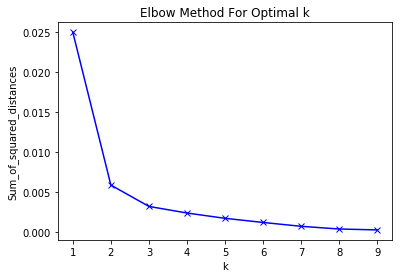

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
% matplotlib inline

Sum_of_squared_distances = []
good_coord = df_good_locations[['Latitude','Longitude']].values
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(good_coord)
    #adding the sum of squared distances for each k to a list
    Sum_of_squared_distances.append(km.inertia_)

#plotting sum of squared distaces against k to find elbow/optimal value
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Using elbow method, optimal k is 5. Applying k-means clustering to coordinates of good locations -

In [39]:
number_of_clusters = 5

good_coord = df_good_locations[['Latitude','Longitude']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_coord)

print('Cluster centers are: ', kmeans.cluster_centers_)

Cluster centers are:  [[ 40.75535775 -73.99238908]
 [ 40.79918542 -73.9574549 ]
 [ 40.81883826 -73.95009481]
 [ 40.72534941 -73.98761782]
 [ 40.76215961 -73.94916769]]


Plotting the good locations on heatmap of fitness centers -

In [40]:
map_mh = folium.Map(height=2000,location=mh_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_mh)
HeatMap(fitness_latlons).add_to(map_mh)
folium.Circle(mh_center, radius=9000, color='white', fill=True, fill_opacity=0.4).add_to(map_mh)
folium.Marker(mh_center).add_to(map_mh)
for center in kmeans.cluster_centers_:
    folium.Circle([center[0], center[1]], radius=500, color='black', fill=True, fill_opacity=0.25).add_to(map_mh) 
for lat, lon in zip(df_good_locations['Latitude'], df_good_locations['Longitude']):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_mh)
folium.GeoJson(mh_neighborhoods, name='geojson').add_to(map_mh)
map_mh

The clusters represent groupings of most of the candidate locations and cluster centers are placed in the middle of these location candidates.

Zones on a city map without heatmap, using shaded areas to indicate clusters:

In [41]:
map_mh = folium.Map(height=1000,location=mh_center, zoom_start=12)
folium.Marker(mh_center).add_to(map_mh)
for lat, lon in zip(df_good_locations['Latitude'], df_good_locations['Longitude']):
    folium.Circle([lat, lon], radius=500, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.3).add_to(map_mh)
for lat, lon in zip(df_good_locations['Latitude'], df_good_locations['Longitude']):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_mh)
for row in kmeans.cluster_centers_:
    folium.Circle([row[0], row[1]], radius=900, color='green', fill=False).add_to(map_mh) 
folium.GeoJson(mh_neighborhoods, style_function=boroughs_style, name='geojson').add_to(map_mh)
map_mh

Addresses of these cluster centers help to find the best possible locations/neighborhoods to open new gym/yoga studio. Hence, using geocode for those candidate centers and getting the addresses which can be presented to stakeholders - 

In [42]:
#to print data in table format
!pip install texttable
from texttable import Texttable

  Running setup.py bdist_wheel for texttable ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a7/4e/77/da46da4c5aece69b701cf45e6e4fe56ff98bfbdcc7b271d03b
Successfully built texttable


In [43]:
t = Texttable()
t.add_row(['Address', 'Distance in km'])
candidate_area_addresses = []
print('Addresses of centers of areas recommended for further analysis')
for row in kmeans.cluster_centers_:   
    location = geolocator.geocode("{}, {}".format(row[0],row[1]))
    candidate_area_addresses.append(location.address)
    d = distance.distance(row, mh_center).km 
    t.add_row([location.address, d])

print(t.draw())

Addresses of centers of areas recommended for further analysis
+-------------------------------------------------------------+----------------+
| Address                                                     | Distance in km |
+-------------------------------------------------------------+----------------+
| 319, West 38th Street, Garment District, Manhattan,         | 0.561          |
| Manhattan Community Board 4, New York County, NYC, New      |                |
| York, 10018, USA                                            |                |
+-------------------------------------------------------------+----------------+
| North Woods, East Drive, Central Park, Manhattan, New York  | 5.287          |
| County, NYC, New York, 10026, USA                           |                |
+-------------------------------------------------------------+----------------+
| A Philip Randolph Campus High School, West 135th Street,    | 7.526          |
| Hamilton Heights, Manhattan, Manhattan Commu

This concludes the analysis. It determines the 5 addresses representing centers of zones containing locations with low number of fitness centers and no Gym/Yoga Studio nearby, all zones being close to city center(within 8 km from Times Square). 
Although zones are shown on map with a radius of ~900 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search of potential gym/yoga studio locations. These addresses mainly belong to neighborhoods - Chelsea and Clinton, Central Harlem, Lower East Side and Upper East Side.

Plotting the cluster center addresses -

In [44]:
map_mh = folium.Map(height=1000,location=mh_center, zoom_start=12)
folium.Circle(mh_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_mh)
for lonlat, addr in zip(kmeans.cluster_centers_, candidate_area_addresses):    
    folium.Marker([lonlat[0], lonlat[1]], popup=addr).add_to(map_mh) 
for lat, lon in zip(df_good_locations['Latitude'], df_good_locations['Longitude']):  
    folium.Circle([lat, lon], radius=500, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.30).add_to(map_mh)
map_mh

## Results and Discussion <a name=results></a>
The analysis shows that although there is a great number of fitness centers in Manhattan (within 1 km around each neighborhood), there are some neighborhoods(close to city center) with low density of fitness centers as compared to others. 

Highest concentration of fitness centers was detected west and south from Times Square whereas lowest concentration was detected in north-east, east and south-east. Those locations were then filtered so that those with more than 95 restaurants in radius of 1km and those with Gym/Yoga Studio closer than 150m were removed. Then, they were clustered to create zones of interest. Addresses of centers of those zones were also generated using geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of analysis was 5 zones having the potential of opening new fitness center based on number of fitness centers and distance to existing venues of gym/yoga studios. This, of course, does not imply that those zones are actually optimal locations for a new gym/yoga studio. Purpose of this analysis was to only provide information on neighborhoods close to Manhattan center but not crowded with already existing gym/yoga studios - it is entirely possible that there is a very good reason for small number of fitness centers in any of those neighborhoods, reasons which would make them unsuitable for a new gym/yoga studio regardless of lack of competition in the area. Recommended areas should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name=conclusion></a>
Purpose of this project was to identify Manhattan neighborhood close to center with low number of fitness centers, particularly Gym/Yoga studio, in order to aid stakeholders in narrowing down the search for optimal location for a new Gym/Yoga Studio. 

With calculation of density distribution of fitness centers using Foursquare data, locations optimal for opening Gym/Yoga studio were identified. Clustering of those locations was then performed in order to create major zones of interest and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decision on optimal fitness center location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like residential population, health awareness, real estate availability, prices, social and economic dynamics of every neighborhood etc.